# Analyzing and predicting churn of a telecom company

![title](img/imgchurn.png)

## Problem definition

Churn is a measurement of the percentage of customers that cancel or choose not to renew their subscriptions to any kind of service or, in simpler terms, is the measure of how many customers stop using a product. In this notebook, we will analyze a dataset of a telecomunications company (think ATNT, Verizon, T-Mobile) with the goal of predicting whether or not a customer will churn.

## About the data

The dataset for this project can be found [here](https://www.kaggle.com/datasets/blastchar/telco-customer-churn). It includes information about:
- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

## Importing dependencies

In [108]:
#Data handling
import pandas as pd
import numpy as np

#Data visualization
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Apply the R ggplot style (just because it looks good)
plt.style.use("ggplot")

## Importing and understading the data

In [109]:
df = pd.read_csv('telecom_churn_data.csv')
df.shape

(7043, 21)

We have 7043 rows and 21 variables (1 dependent - churn - and 20 independent) in our dataset

In [110]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [111]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


As we can see, most of the features are categorical. `MonthlyCharges`, which probably should be a numeric column, is and object column (it probabaly has null values ou other type of data, otherwise Pandas would have automatically encoded it as numeric)

## Preparation and transformation

In [113]:
#Dropping the column customerID, since it's of no use for us
df = df.drop(columns=['customerID'], axis=1)

In [114]:
#Converting the TotalCharges column into a numeric format
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

In [115]:
#Checking for null values
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [116]:
#Since we have 11 null values in the TotalCharges column that probably represent recent costumers, we can can drop these 11 rows
df.dropna(axis=0, inplace = True)

In [117]:
#Fixing column names. We want the following format to make our lives easier: word_word
df.columns = df.columns.str.lower()
df.rename(columns={'seniorcitizen':'senior_citizen', 'phoneservice':'phone_service',
                   'multiplelines':'multiple_lines', 'internetservice':'internet_service',
                   'onlinesecurity': 'online_security', 'onlinebackup':'online_backup',
                   'deviceprotection':'device_protection', 'techsupport':'tech_support',
                   'streamingtv':'streaming_tv', 'streamingmovies':'streaming_movies',
                   'paperlessbilling':'paperless_billing', 'paymentmethod':'payment_method',
                   'monthlycharges':'monthly_charges', 'totalcharges':'total_charges'}, inplace=True)
df.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn'],
      dtype='object')

#### Univariate analysis

**Univariate analysis** _ churn variable

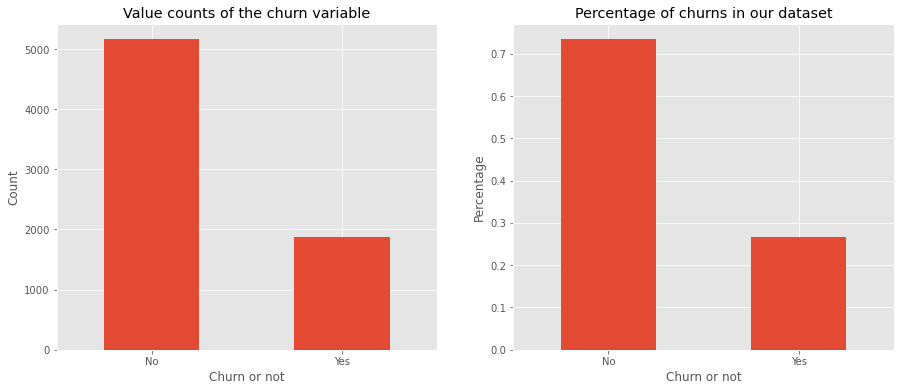

In [118]:
fig = plt.figure(figsize=(15, 6))

fig.add_subplot(121)
df['churn'].value_counts().plot(kind="bar")
#sns.countplot(data = df, x = 'churn')
plt.title("Value counts of the churn variable")
plt.xlabel("Churn or not")
plt.xticks(rotation=0)
plt.ylabel("Count")

fig.add_subplot(122)
df['churn'].value_counts(normalize=True).plot(kind="bar")
#sns.countplot(data = df, x = 'churn')
plt.title("Percentage of churns in our dataset")
plt.xlabel("Churn or not")
plt.xticks(rotation=0)
plt.ylabel("Percentage")

plt.show()



As we can see, about 75% of our dataset is composed of customers that did not churn. This is important for our classification model later on.

**Univariate analysis** _ demographics: gender, senior citizen, partner and dependents variables

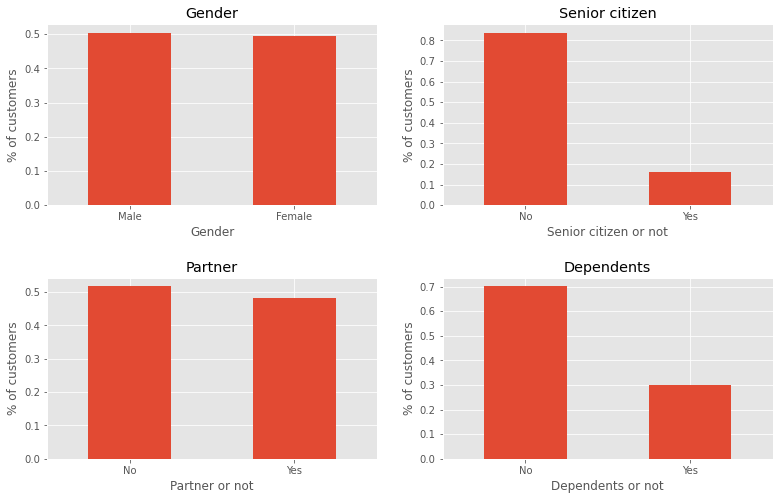

In [119]:
fig = plt.figure(figsize=(13, 8))

#Gender
fig.add_subplot(221)
df['gender'].value_counts(normalize=True).plot(kind="bar")
plt.title("Gender")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.ylabel("% of customers")

#Senior citizen
fig.add_subplot(222)
df['senior_citizen'].map({0:'No', 1:'Yes'}).value_counts(normalize=True).plot(kind="bar")
plt.title("Senior citizen")
plt.xlabel("Senior citizen or not")
plt.ylabel("% of customers")
plt.xticks(rotation=0)

#Partner
fig.add_subplot(223)
df['partner'].value_counts(normalize=True).plot(kind="bar")
plt.title("Partner")
plt.xlabel("Partner or not")
plt.xticks(rotation=0)
plt.ylabel("% of customers")

#Dependents
fig.add_subplot(224)
df['dependents'].value_counts(normalize=True).plot(kind="bar")
plt.title("Dependents")
plt.xlabel("Dependents or not")
plt.ylabel("% of customers")
plt.xticks(rotation=0)

plt.subplots_adjust(wspace=0.2,hspace=0.4)

plt.show()

- Our dataset is pretty even when it comes to gender.
- More than 80% of our dataset is composed of non senior citizens.
- A little bit more than 50% of our customers have a partner
- Almost 70% of our customers have a dependent (which is generally a son/daughter)

**Univariate analysis** _ tenure variable

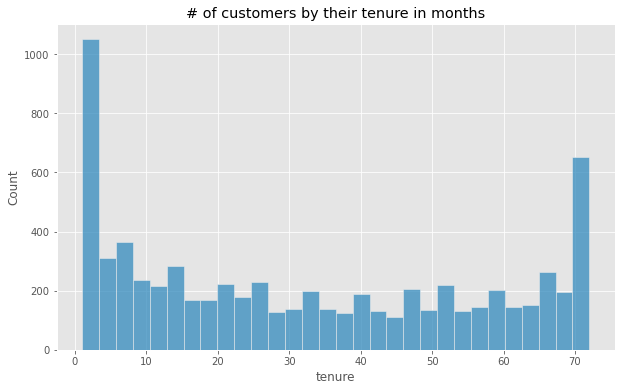

In [120]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(data = df, x = 'tenure', kde=False, bins=30)
plt.title('# of customers by their tenure in months')
plt.show()

The highest number of customers have a short term tenure. Also, there a lot of customers that have a long term tenure. 

**Univariate analysis** _ contract type variable

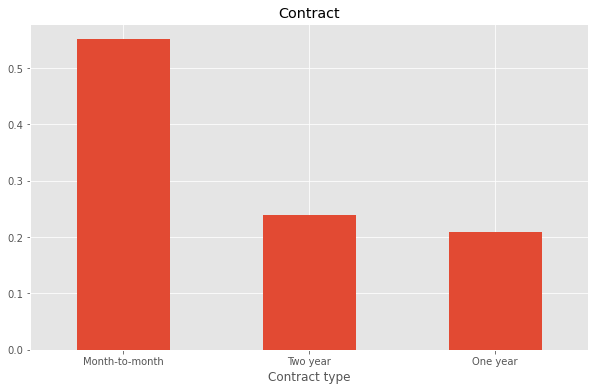

In [121]:
fig = plt.figure(figsize=(10, 6))
df['contract'].value_counts(normalize=True).plot(kind="bar")
plt.title("Contract")
plt.xlabel("Contract type")
plt.xticks(rotation=0)
plt.show()

Most users are on a month-to-month contract. The churn rate amongst those costumers might be higher, since they don't have any contractual obligation keeping them from churning.

**Univariate analysis** _ services used

In [122]:
services=['phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
services_users = {}

for service in services:
    if service == 'internet_service':
        services_users[service] = df[df[service]!='No'].shape[0]
    else:
        services_users[service] = df[df[service]=='Yes'].shape[0]

In [123]:
users = pd.DataFrame(services_users.items(), columns=['service', 'users'])
users.sort_values('users', ascending=False, inplace=True)

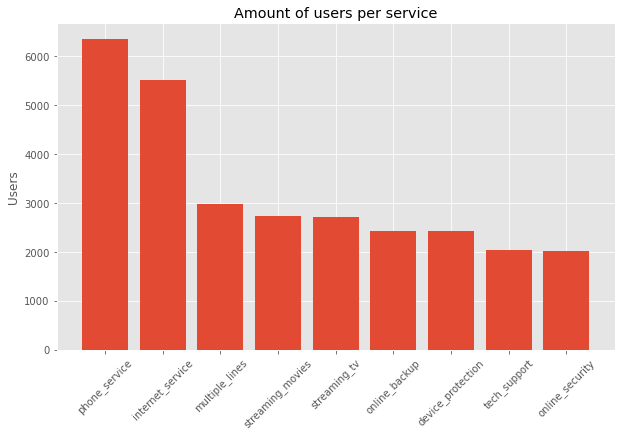

In [124]:
fig = plt.figure(figsize=(10, 6))
plt.bar(users['service'], users['users'])
plt.title("Amount of users per service")
plt.ylabel("Users")
plt.xticks(rotation=45)
plt.show()

The most popular services in our telecom network are phone and internet services, as expected. Tech support and online security, on the other hand, are the most impopular services.

#### Multivariate analysis

**Multivariate analysis** _ churn vs demographics variables

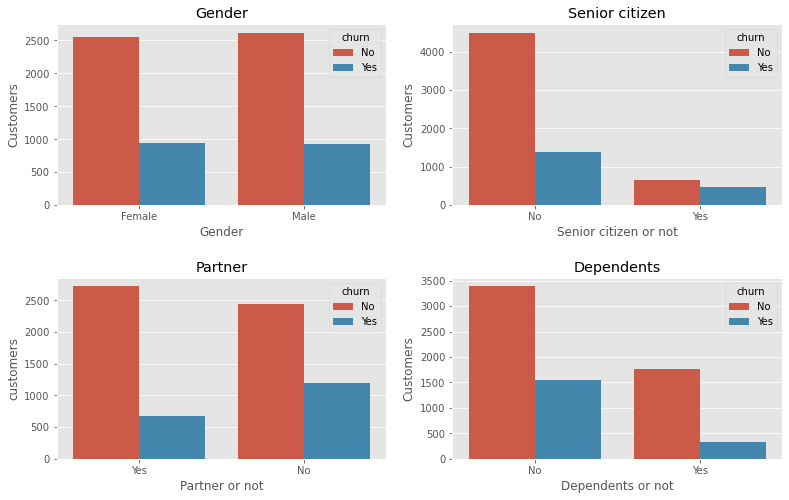

In [125]:
fig = plt.figure(figsize=(13, 8))

#Gender
fig.add_subplot(221)
sns.countplot(data = df, x='gender', hue='churn')
plt.title("Gender")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.ylabel("Customers")

#Senior citizen
fig.add_subplot(222)
sns.countplot(data = df, x = df['senior_citizen'].map({0:'No', 1:'Yes'}), hue='churn')
plt.title("Senior citizen")
plt.xlabel("Senior citizen or not")
plt.ylabel("Customers")
plt.xticks(rotation=0)

#Partner
fig.add_subplot(223)
sns.countplot(data = df, x = 'partner', hue='churn')
plt.title("Partner")
plt.xlabel("Partner or not")
plt.xticks(rotation=0)
plt.ylabel("Customers")
plt.ylabel("customers")

#Dependents
fig.add_subplot(224)
sns.countplot(data = df, x = 'dependents', hue='churn')
plt.title("Dependents")
plt.xlabel("Dependents or not")
plt.ylabel("Customers")
plt.xticks(rotation=0)

plt.subplots_adjust(wspace=0.2,hspace=0.4)

plt.show()

**Multivariate analysis** _ tenure

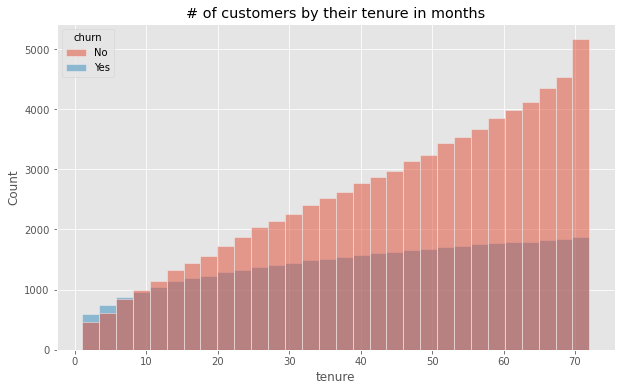

In [126]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(data = df, x = 'tenure', hue = 'churn', cumulative = True, kde=False, bins=30)
plt.title('# of customers by their tenure in months')
plt.show()

**Multivariate analysis** _ churn vs contract type

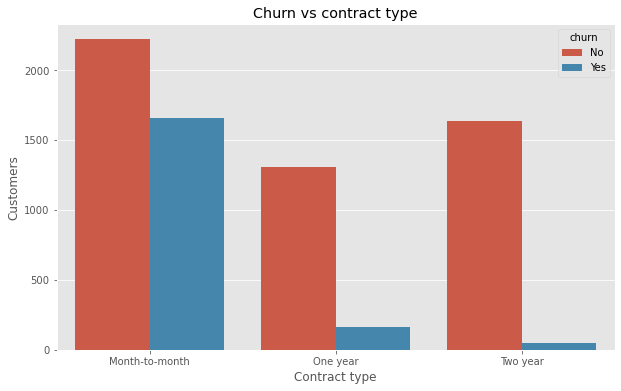

In [127]:
fig = plt.figure(figsize=(10, 6))
sns.countplot(data = df, x='contract', hue='churn')
plt.title("Churn vs contract type")
plt.xlabel("Contract type")
plt.xticks(rotation=0)
plt.ylabel("Customers")
plt.show()

**Multivariate analysis** _ churn vs total and monthly charges

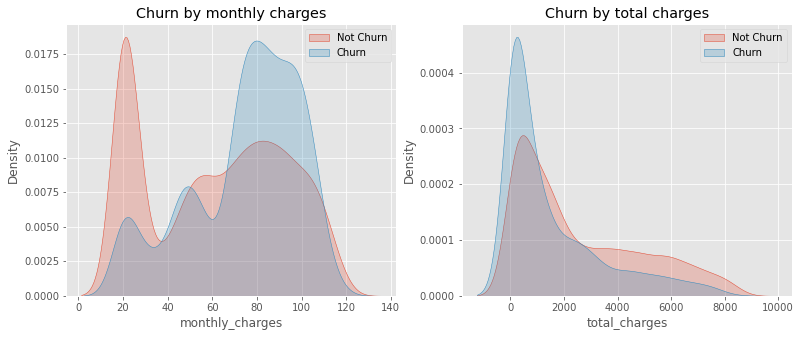

In [128]:
fig = plt.figure(figsize=(13, 5))

fig.add_subplot(121)
sns.kdeplot(df['monthly_charges'][df['churn']=='No'], shade=True)
sns.kdeplot(df['monthly_charges'][df['churn']=='Yes'], shade=True)
plt.legend(["Not Churn","Churn"],loc='upper right')
plt.title("Churn by monthly charges")

fig.add_subplot(122)
sns.kdeplot(df['total_charges'][df['churn']=='No'], shade=True)
sns.kdeplot(df['total_charges'][df['churn']=='Yes'], shade=True)
plt.legend(["Not Churn","Churn"],loc='upper right')
plt.title("Churn by total charges")

plt.subplots_adjust(wspace=0.2,hspace=0.4)
plt.show()

**Multivariate analysis** _ correlation matrix

We will let the correlation heatmap matrix for later, when we have our dataset encoded :D

## Modeling and classification

### Encoding
As we can see, there are a lot of object values in the dataset. In the next steps we will convert them to numeric values. Encoding is going to be useful whenever we start applying our models. We will create functions to encode our binary, ordinal and nominal features.

In [129]:
#Create a copy of our dataframe
customers = df.copy()

In [130]:
#Function to get unique values for our features
def get_uniques(df, columns):
    return {column: list(df[column].unique()) for column in columns}

In [131]:
get_uniques(customers, ['gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method', 'churn'])

{'gender': ['Female', 'Male'],
 'senior_citizen': [0, 1],
 'partner': ['Yes', 'No'],
 'dependents': ['No', 'Yes'],
 'phone_service': ['No', 'Yes'],
 'multiple_lines': ['No phone service', 'No', 'Yes'],
 'internet_service': ['DSL', 'Fiber optic', 'No'],
 'online_security': ['No', 'Yes', 'No internet service'],
 'online_backup': ['Yes', 'No', 'No internet service'],
 'device_protection': ['No', 'Yes', 'No internet service'],
 'tech_support': ['No', 'Yes', 'No internet service'],
 'streaming_tv': ['No', 'Yes', 'No internet service'],
 'streaming_movies': ['No', 'Yes', 'No internet service'],
 'contract': ['Month-to-month', 'One year', 'Two year'],
 'paperless_billing': ['Yes', 'No'],
 'payment_method': ['Electronic check',
  'Mailed check',
  'Bank transfer (automatic)',
  'Credit card (automatic)'],
 'churn': ['No', 'Yes']}

In [132]:
binary_features = ['gender', 'partner', 'dependents', 'phone_service', 'paperless_billing', 'churn']

In [133]:
ordinal_features = ['multiple_lines',  'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_movies', 'streaming_tv', 'contract', 'internet_service', 'payment_method']

In [134]:
nominal_features = [] #we are assuming we dont have nominal features

In [135]:
#Creating a function to encode binary features
def binary_encode(df, column, positive_label):
    df = df.copy()
    df[column] = df[column].apply(func = lambda x: 1 if x == positive_label else 0)
    return df

In [136]:
#Creating a function to encode ordinal features
def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df

In [137]:
#Creating a function to nominal features (we have none is this case)
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column])
    df = pd.concat([df, dummies], axis = 1)
    df.drop(column, axis=1, inplace=True)
    return df

In [138]:
#Encoding binary features
customers = binary_encode(customers, 'gender', 'Male')
customers = binary_encode(customers, 'partner', 'Yes')
customers = binary_encode(customers, 'dependents', 'Yes')
customers = binary_encode(customers, 'phone_service', 'Yes')
customers = binary_encode(customers, 'paperless_billing', 'Yes')
customers = binary_encode(customers, 'churn', 'Yes')

In [139]:
#Encoding ordinal features
customers = ordinal_encode(customers, 'online_security', ['No internet service', 'No', 'Yes'])
customers = ordinal_encode(customers, 'online_backup', ['No internet service', 'No', 'Yes'])
customers = ordinal_encode(customers, 'device_protection', ['No internet service', 'No', 'Yes'])
customers = ordinal_encode(customers, 'tech_support', ['No internet service', 'No', 'Yes'])
customers = ordinal_encode(customers, 'streaming_tv', ['No internet service', 'No', 'Yes'])
customers = ordinal_encode(customers, 'streaming_movies', ['No internet service', 'No', 'Yes'])
customers = ordinal_encode(customers, 'contract', ['Month-to-month', 'One year', 'Two year'])
customers = ordinal_encode(customers, 'multiple_lines', ['No phone service', 'No', 'Yes'])
customers = ordinal_encode(customers, 'internet_service', ['No', 'DSL', 'Fiber optic'])
customers = ordinal_encode(customers, 'payment_method', ['Mailed check', 'Electronic check', 'Bank transfer (automatic)', 'Credit card (automatic)'])

In [140]:
customers.head(5)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,0,0,1,0,1,0,0,1,1,2,1,1,1,1,0,1,1,29.85,29.85,0
1,1,0,0,0,34,1,1,1,2,1,2,1,1,1,1,0,0,56.95,1889.50,0
2,1,0,0,0,2,1,1,1,2,2,1,1,1,1,0,1,0,53.85,108.15,1
3,1,0,0,0,45,0,0,1,2,1,2,2,1,1,1,0,2,42.30,1840.75,0
4,0,0,0,0,2,1,1,2,1,1,1,1,1,1,0,1,1,70.70,151.65,1


Before we dive into our model, let's plot the correlation heatmap for our dataset with encoded variables

<AxesSubplot:>

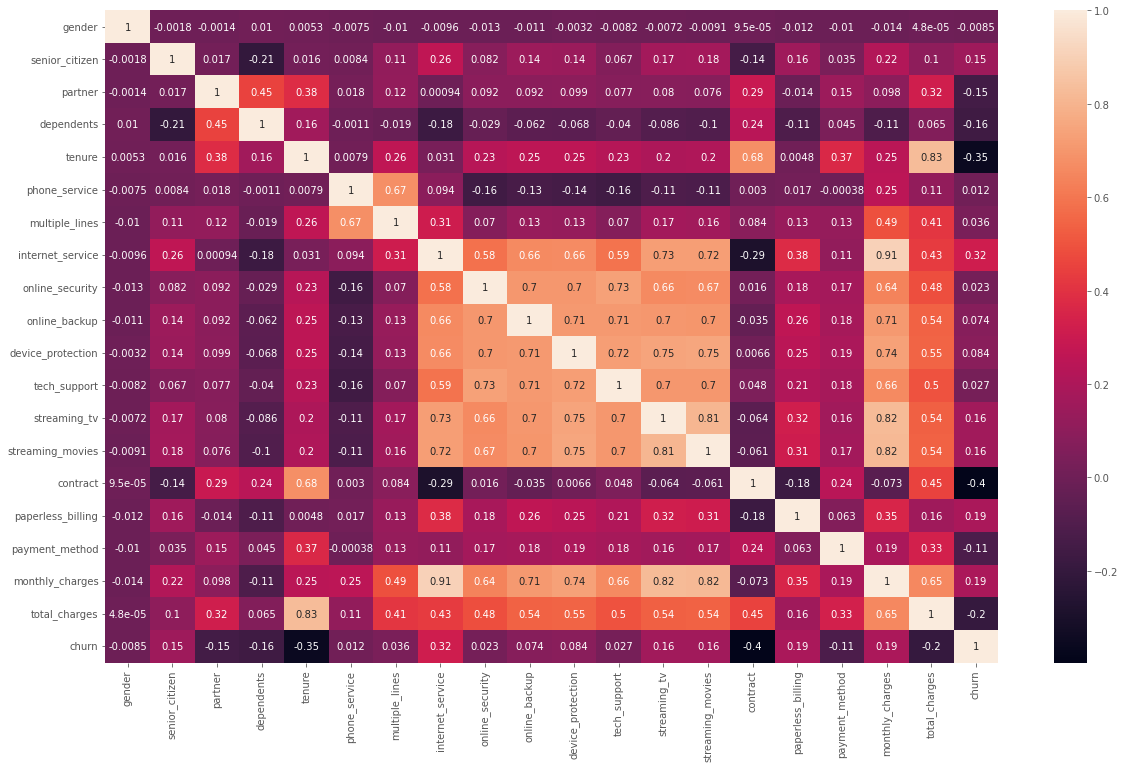

In [141]:
fig = plt.figure(figsize=(20, 12))
sns.heatmap(customers.corr(), annot=True)

### Scaling and Spliting the dataset

In [142]:
y = customers['churn']
X = customers.drop('churn', axis =1)

In [143]:
scaler = StandardScaler() #brings the mean to zero and the variance to unit
X = scaler.fit_transform(X)

In [144]:
#Spliting the X and y into train and test. We will use a train size of 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 0)

### Training and evaluating our models (Logistic Regression and KNN)

In [145]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

knn =  KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [146]:
#Model evaluation
print("-------- Logistic Regression --------")
print(f" Accuracy: {accuracy_score(y_test, logreg.predict(X_test))}")
print(f"Precision: {precision_score(y_test, logreg.predict(X_test))}")
print(f"   Recall: {recall_score(y_test, logreg.predict(X_test))}")
print(f" F1 Score: {f1_score(y_test, logreg.predict(X_test))}")

print("\n---------------- KNN ----------------")
print(f" Accuracy: {accuracy_score(y_test, knn.predict(X_test))}")
print(f"Precision: {precision_score(y_test, knn.predict(X_test))}")
print(f"   Recall: {recall_score(y_test, knn.predict(X_test))}")
print(f" F1 Score: {f1_score(y_test, knn.predict(X_test))}")

-------- Logistic Regression --------
 Accuracy: 0.7966824644549763
Precision: 0.6375545851528385
   Recall: 0.5261261261261261
 F1 Score: 0.5765054294175717

---------------- KNN ----------------
 Accuracy: 0.7748815165876777
Precision: 0.591743119266055
   Recall: 0.4648648648648649
 F1 Score: 0.520686175580222


Overall, the Logistici Regression model is performing better. In this case, precision is very important due to the fact that our Churn class is not very well balanced. Only 26% percent of our customers churn, so if our model somehow predicted zeros for every row, we would have an accuracy of 74%, even tho we completely failed to classify our data. Our 65% precision means the model did a good job correctly classifying churn cases.

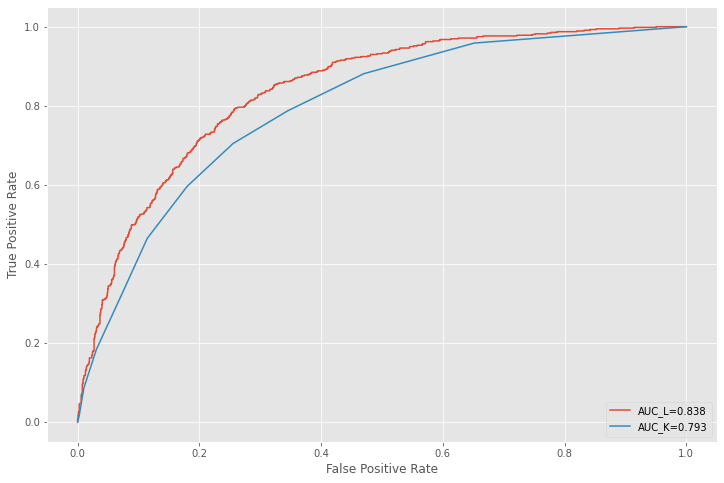

In [147]:
#Receiver operating characteristic (ROC) curve and area under curve (AUC)
fig = plt.figure(figsize=(12, 8))
for model in [logreg, knn]:
    #Parameters
    y_pred = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    #Plotting
    plt.plot(fpr, tpr, label=f"AUC_{str(model)[:1]}={round(auc,3)}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
plt.show()

The AUC once again confirms that, for this particular case, the Logistic Regression model is doing a better job of classifying churns.

### Feature importance

Since the Logistic Regression proved to be the best model out of the two, let's inspect feature importance for this particular model

In [148]:
feature_names = [x for x in df.columns if x not in ('churn')]
coef = logreg.coef_[0] #these are the coefficients of our logistic regression, which is a parametric model (unlike KNN, for example)

In [149]:
#Creating the feature importance dataset
feature_importance = pd.DataFrame(feature_names, columns=["feature"])
feature_importance['importance'] = coef
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

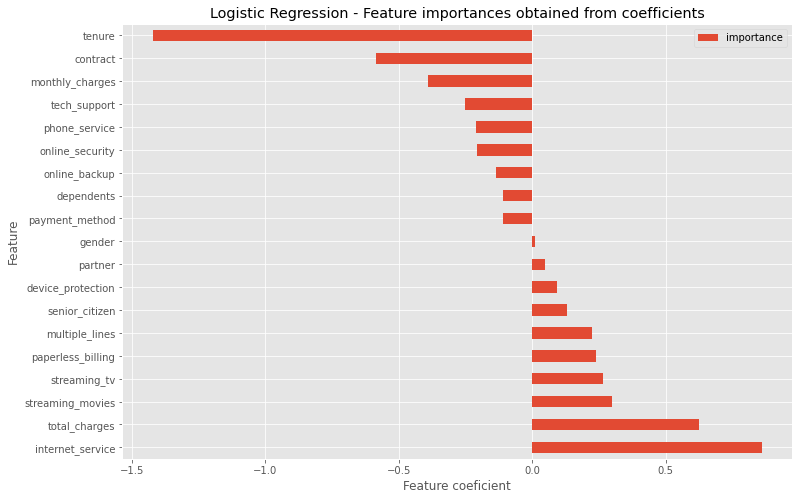

In [150]:
#Plotting feature importance
feature_importance.plot(x ='feature', y='importance', kind = 'barh', figsize=(12,8))
plt.xlabel('Feature coeficient')
plt.ylabel('Feature')
plt.title('Logistic Regression - Feature importances obtained from coefficients')
plt.show()

Positive coeficients contribute to the positive class (churn), while negative coefficients contribute to the negative class (not churn)

## Conclusions

- We analyzed a dataframe of more than 7000 costumers of a telecomunications company in order to predict which costumers will churn
- About 25% of our dataset churned. We assumed that the imbalance was not enough to justify applying balancing methods such and under or oversampling
- Throughout our initial exploratory analysis, we hypothesized that the following groups were more likely to churn:
    - Senior costumers
    - Costumers on a month-to-month contract
    - Costumers with higher monthly charges
    - Costumers with a short tenure time
- Our dataset was then split into train and test data with a train size of 70%, which means we will have 30% of our samples to test our models
- We scaled the data to bring the mean of our values to 0 and the variance to 1
- We used two ML models for our classification task: Logistic Regression and K-Nearest Neighbors (KNN)
- The Logistic Regression method had better performance metrics all accross the board: accuracy, precision, recall, F1 score, AUC. We could work on trying to improve those metrics, but we will choose not to right now.
- Examining the feature importance of our features using their respective coefficients for the LR curve, we got the following results:
    - The tenure feature is indeed the most import feature of our model: higher values of tenure means the costumer is less likely to churn, since the coefficiente is negative
    - The contract feature is also contributes negatively to our output varible. The higher the contract feature (eg Two-years), the lower the change the costumer will churn
    - Internet service contributes positively, meaning that clients with more sophisticated internet service (eg Fiber optic) are more likely to churn (probably because this leads to a higher monthly charge)
